<h1 style='text-align:center;color:#ff7392'><strong>Introduction To Data Visualizations and Exploraiton</strong></h1>
<h3 style='text-align:center;color:#FFC0CB'><strong>Assignment 1</strong></h3>
<h6 style='color:lightcoral'><strong>1858893: Molefe Molefe</strong></h6>
<h6 style='color:lightcoral'><strong>1814731: Shameel Nkosi</strong></h6>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')


<a id="section_n" name="section_n"></a>

## Table of Contents
* [1. Introduction](#chapter2)
    * [Additional Filters](#section_2_1)
* [2. Gaussian Edge and Bar Filters - The RFS/MR8 Filter Banks](#chapter3)
    * [Edge Filters](#section_3_1)
    * [Bar Filters](#section_3_2)
    * [Root Filter Set](#section_3_3)
    * [MR8](#section_3_4)
* [3. Local Binary Patterns and Haar Filters](#chapter4)
    * [Implement The Local Binary Pattern and Apply It To Training Image](#section_4_1)
    * [Integral Image](#section_4_2)
    * [Applying Checkered Haar Filter](#section_4_3)
* [4. Textons and Classification](#chapter5)
    * [Applying Feature Extraction Methods To Image](#section_5_1)
    * [Replace Pixels of Image With Corresponding Centroid](#section_5_2)
    * [Training Background Classifier on Current Set of Features](#section_5_3)
    * [Find The Accuracy of The Model](#section_5_4)
* [5. Applying The MR8 Feature Bank on The HSV Pixels](#chapter6)
* [6. Applying Adjustments To Model](#chapter7)

<a id="chapter2" name="chapter2">Chapter 2</a>

<h2 style='text-align:center;color:#ff7392'><strong>1. Glass Identification Databse </strong></h2>

In [2]:
def plot_distribution(dataset, cols=5, width=20, height=15, hspace=0.2, wspace=0.5):
    plt.style.use('seaborn-whitegrid')
    fig = plt.figure(figsize=(width,height))
    fig.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=wspace, hspace=hspace)
    rows = math.ceil(float(dataset.shape[1]) / cols)
    for i, column in enumerate(dataset.columns):
        ax = fig.add_subplot(rows, cols, i + 1)
        ax.set_title(column)
        if dataset.dtypes[column] == np.object:
            g = sns.countplot(y=column, data=dataset)
            substrings = [s.get_text()[:18] for s in g.get_yticklabels()]
            g.set(yticklabels=substrings)
            plt.xticks(rotation=25)
        else:
            g = sns.distplot(dataset[column])
            plt.xticks(rotation=25)

<a id="section_2_1" name="section_2_1">Section 2.1 </a>

<h4 style="color:#ff7392"><strong>Read In Data</strong></h4>

> <strong>Missing Values: </strong> None

In [3]:
columns = ['ID','RI','Na','Mg','Al','Si','K','Ca','Ba','Fe','Type']

In [4]:
glass_df = pd.read_csv('glass/glass.data',header=None)
glass_df.columns = columns
glass_df.set_index('ID',inplace=True)

In [5]:
glass_df.isnull().sum()

RI      0
Na      0
Mg      0
Al      0
Si      0
K       0
Ca      0
Ba      0
Fe      0
Type    0
dtype: int64

In [6]:
glass_df.dtypes.to_frame().T

,RI,Na,Mg,Al,Si,K,Ca,Ba,Fe,Type
0,float64,float64,float64,float64,float64,float64,float64,float64,float64,int64


In [7]:
glass_df.Type = glass_df.Type.astype('object')

In [8]:
glass_df

,RI,Na,Mg,Al,Si,K,Ca,Ba,Fe,Type
ID,,,,,,,,,,
1,1.52101,13.64,4.49,1.10,71.78,0.06,8.75,0.00,0.0,1
2,1.51761,13.89,3.60,1.36,72.73,0.48,7.83,0.00,0.0,1
3,1.51618,13.53,3.55,1.54,72.99,0.39,7.78,0.00,0.0,1
4,1.51766,13.21,3.69,1.29,72.61,0.57,8.22,0.00,0.0,1
5,1.51742,13.27,3.62,1.24,73.08,0.55,8.07,0.00,0.0,1
...,...,...,...,...,...,...,...,...,...,...
210,1.51623,14.14,0.00,2.88,72.61,0.08,9.18,1.06,0.0,7
211,1.51685,14.92,0.00,1.99,73.06,0.00,8.40,1.59,0.0,7
212,1.52065,14.36,0.00,2.02,73.42,0.00,8.44,1.64,0.0,7


In [9]:
np.amin(glass_df),np.amax(glass_df)

(RI      1.51115
 Na        10.73
 Mg          0.0
 Al         0.29
 Si        69.81
 K           0.0
 Ca         5.43
 Ba          0.0
 Fe          0.0
 Type          1
 dtype: object,
 RI      1.53393
 Na        17.38
 Mg         4.49
 Al          3.5
 Si        75.41
 K          6.21
 Ca        16.19
 Ba         3.15
 Fe         0.51
 Type          7
 dtype: object)

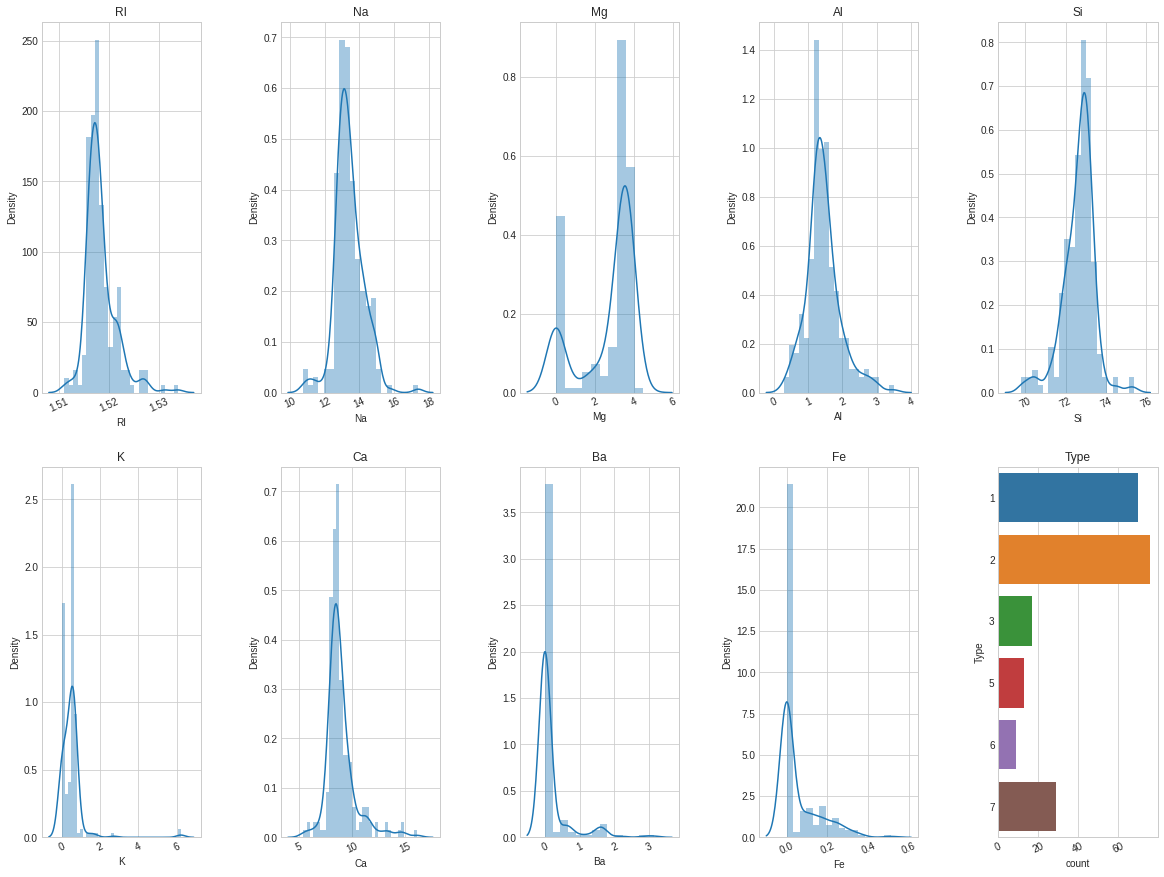

In [10]:
plot_distribution(glass_df)

In [11]:
glass_data = (glass_df.values[:,:-1]).astype(np.float64)
glass_target = glass_df.values[:,-1]
cov_data = np.corrcoef(glass_data.T)

(-0.5, 8.5, 8.5, -0.5)

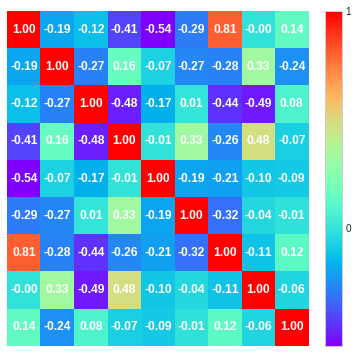

In [12]:
plt.figure(figsize=(6,6))
visualize_covariance = plt.matshow(cov_data,cmap=plt.cm.rainbow,fignum=1,aspect='auto')
plt.colorbar(visualize_covariance,ticks=[-1,0,1],fraction=0.05)
for x in range(cov_data.shape[0]):
    for y in range(cov_data.shape[1]):
        plt.text(x,y,"%0.2f"%cov_data[x,y],size=12,color='white',weight='bold',ha='center',va='center')
        
plt.axis('off')

In [13]:
colors = ['red','blue','orange','green','yellow','gray','teal','pink']

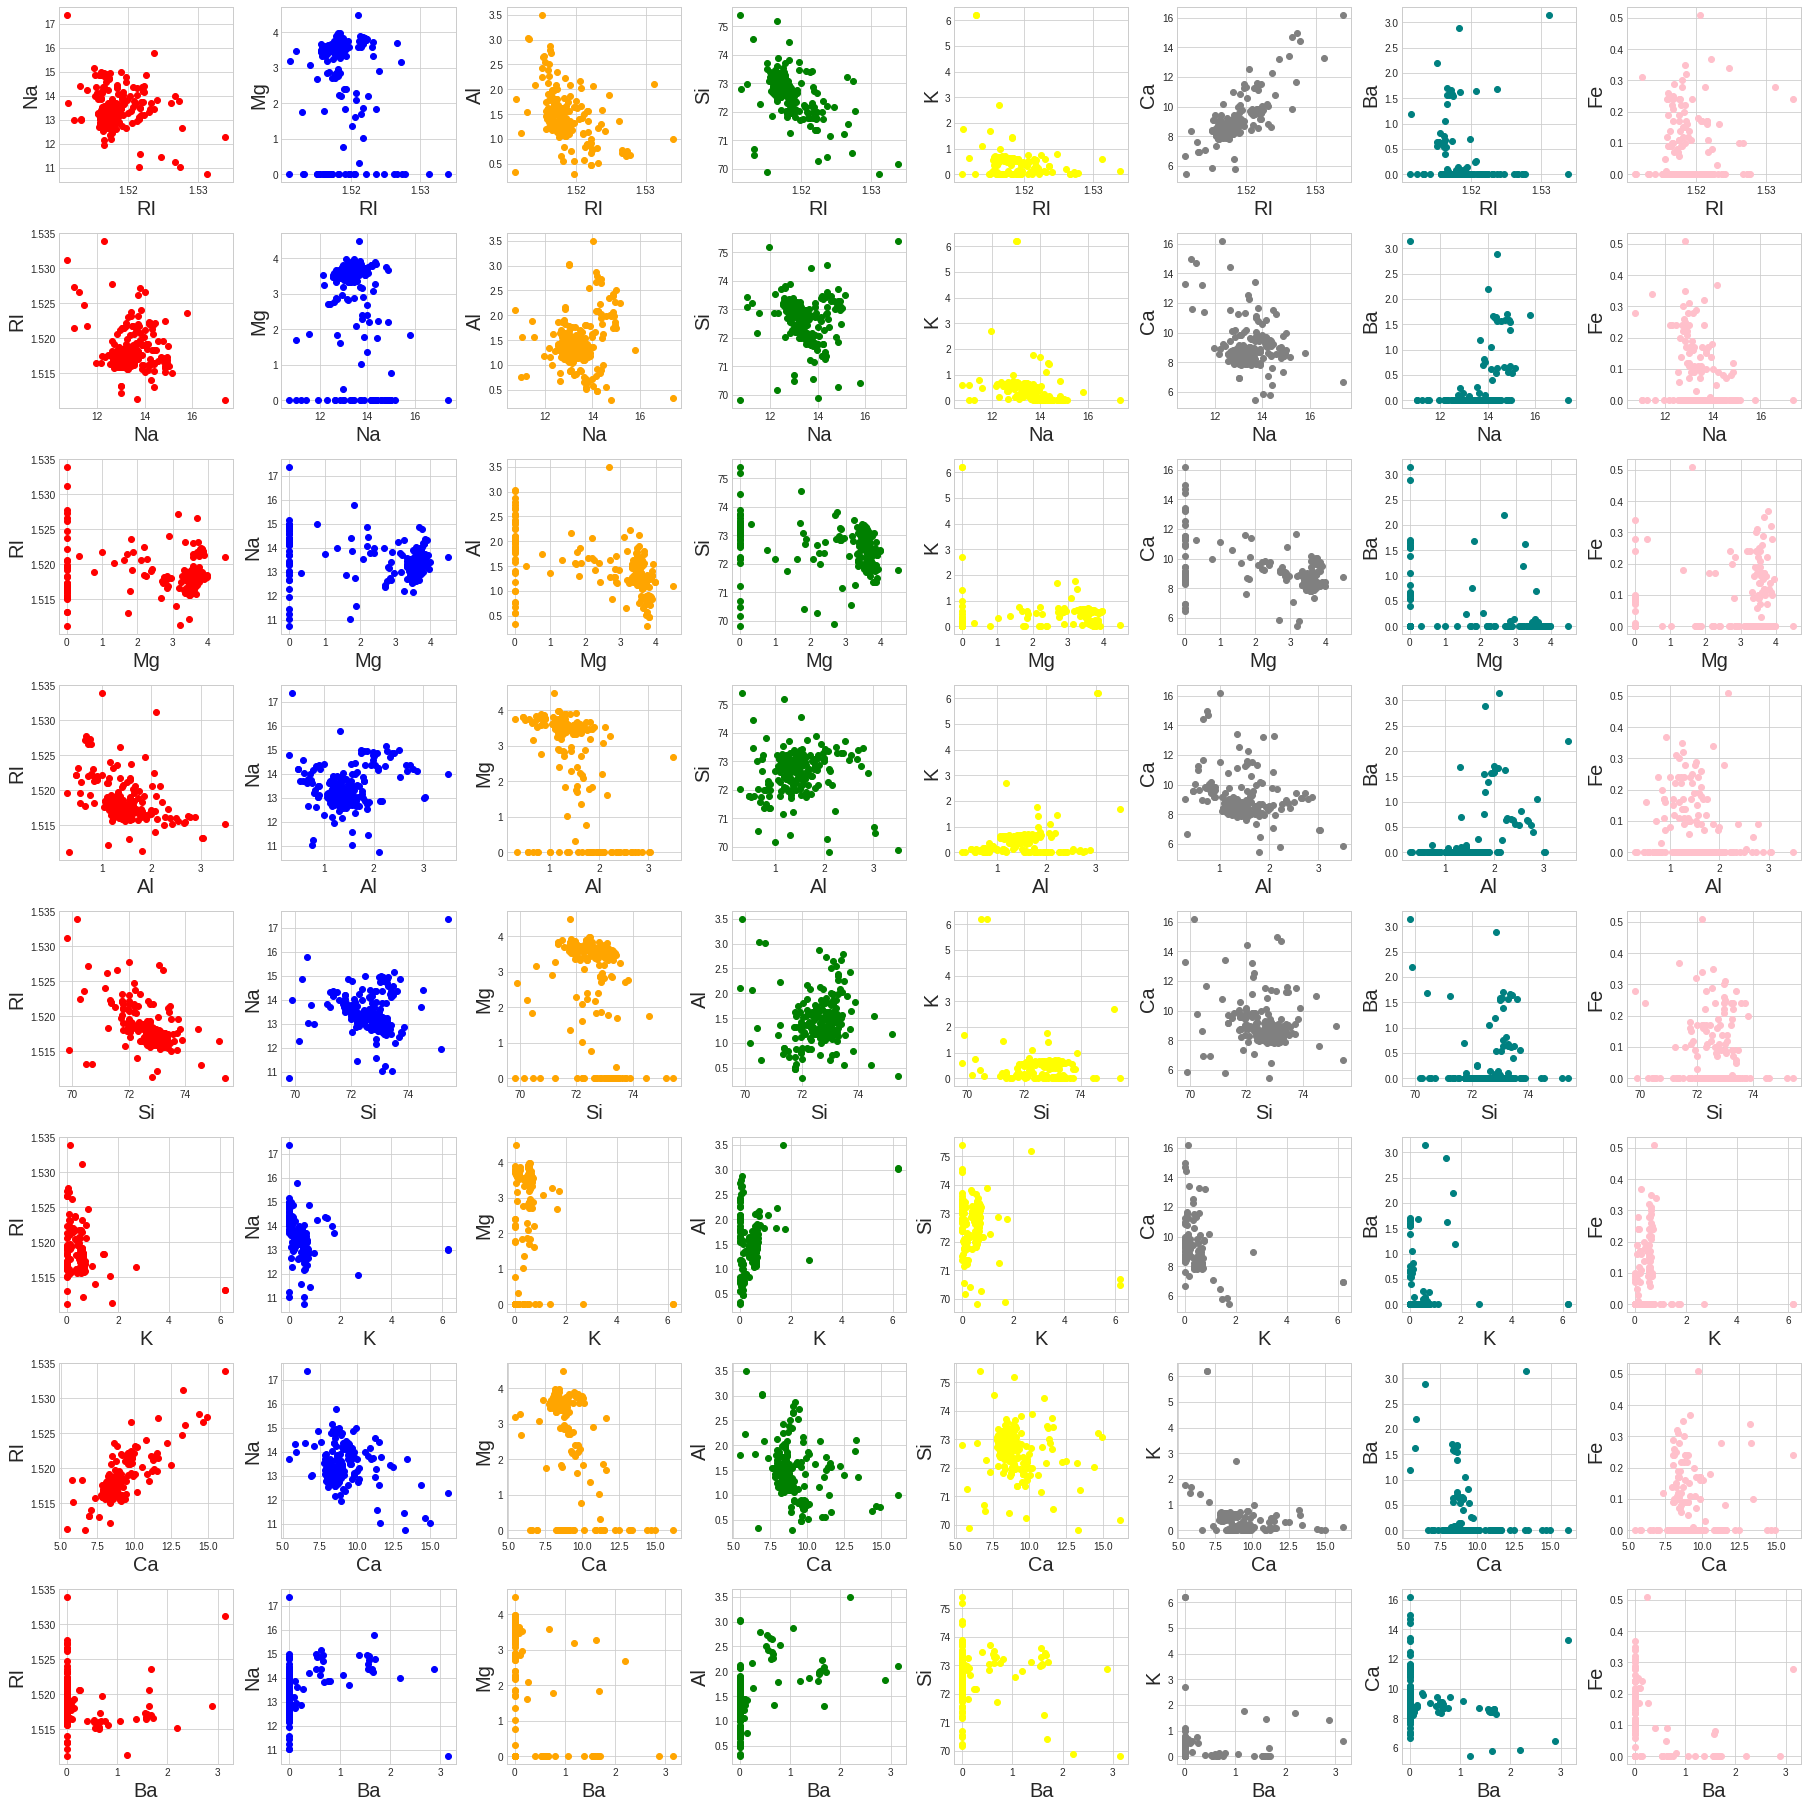

In [14]:
fig1, f1_axes = plt.subplots(ncols=8, nrows=8, constrained_layout=True,figsize=(25,25))
for row in range(len(columns[1:9])):
    chosen = columns[1:-1][row]
    other_columns =[col for col in columns[1:-1] if col != chosen ]
    for col in range(len(other_columns)):
        f1_axes[row,col].scatter(glass_df[chosen],glass_df[other_columns[col]],color=colors[col])
        f1_axes[row][col].set_xlabel(chosen,fontsize=20)
        f1_axes[row][col].set_ylabel(other_columns[col],fontsize=20)    

In [15]:
colors2 = ['red','blue','orange','green','yellow','gray','teal','pink','purple']

9

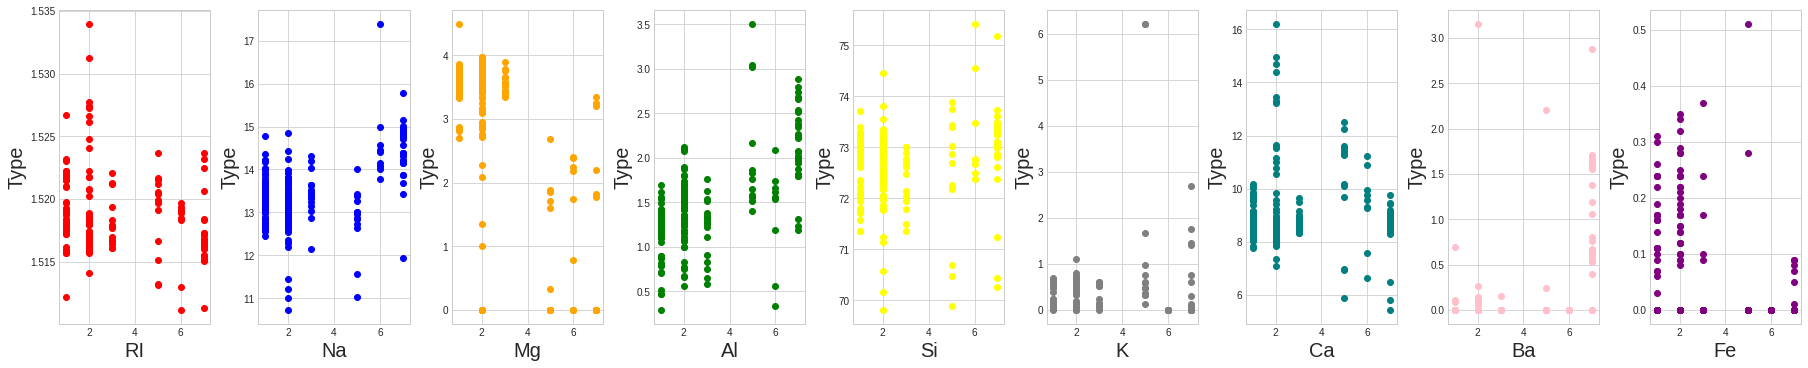

In [16]:
fig2, f2_axes = plt.subplots(ncols=9, nrows=1, constrained_layout=True,figsize=(25,5))
chosen = 'Type'
other_columns =[col for col in columns[1:-1] if col != chosen ]
for col in range(len(other_columns)):
    f2_axes[col].scatter(glass_df[chosen],glass_df[other_columns[col]],color=colors2[col])
    f2_axes[col].set_xlabel(other_columns[col],fontsize=20)
    f2_axes[col].set_ylabel(chosen,fontsize=20)    
# # columns[1:]
len(other_columns)

In [17]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn import metrics
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.linear_model import LogisticRegression
import math

In [20]:
glass_target = glass_target.astype(np.uint8)

<a id="section_2_1" name="section_2_1">Section 2.1 </a>

<h4 style="color:#ff7392"><strong>Without Standardization</strong></h4>


In [21]:
X_train,X_test,y_train,y_test = train_test_split(glass_data,glass_target,test_size=0.2,random_state=0)

In [22]:
regressor = RandomForestRegressor(n_estimators=20,random_state=0)

In [23]:
regressor.fit(X_train,y_train)
y_pred = regressor.predict(X_test)
preds = [math.ceil(pred) for pred in y_pred]

In [24]:
print("Confusion Matrix: \n",confusion_matrix(y_test,preds))
print("=============================================")
print(classification_report(y_test,preds))
print("=============================================")
print("Accuracy: {}%".format(accuracy_score(y_test, preds)))

Confusion Matrix: 
 [[ 3  5  1  0  0  0  0]
 [ 0 15  3  1  0  0  0]
 [ 0  2  3  0  0  0  0]
 [ 0  0  0  0  0  0  0]
 [ 0  0  1  0  1  0  0]
 [ 0  0  0  0  1  1  0]
 [ 0  0  0  0  0  1  5]]
              precision    recall  f1-score   support

           1       1.00      0.33      0.50         9
           2       0.68      0.79      0.73        19
           3       0.38      0.60      0.46         5
           4       0.00      0.00      0.00         0
           5       0.50      0.50      0.50         2
           6       0.50      0.50      0.50         2
           7       1.00      0.83      0.91         6

    accuracy                           0.65        43
   macro avg       0.58      0.51      0.51        43
weighted avg       0.74      0.65      0.65        43

Accuracy: 0.6511627906976745%


In [25]:
clf = LogisticRegression(random_state=0).fit(X_train, y_train)
y_preds = clf.predict(X_test)

In [26]:
print("Logistic Regression Confusion Matrix: \n",confusion_matrix(y_test,y_preds))
print("=============================================")
print(classification_report(y_test,y_preds))
print("=============================================")
print("Logistic Regression Accuracy: {}%".format(accuracy_score(y_test, y_preds)))

Logistic Regression Confusion Matrix: 
 [[ 6  3  0  0  0  0]
 [10  8  0  1  0  0]
 [ 3  2  0  0  0  0]
 [ 0  1  0  1  0  0]
 [ 0  1  0  0  0  1]
 [ 0  0  0  0  1  5]]
              precision    recall  f1-score   support

           1       0.32      0.67      0.43         9
           2       0.53      0.42      0.47        19
           3       0.00      0.00      0.00         5
           5       0.50      0.50      0.50         2
           6       0.00      0.00      0.00         2
           7       0.83      0.83      0.83         6

    accuracy                           0.47        43
   macro avg       0.36      0.40      0.37        43
weighted avg       0.44      0.47      0.44        43

Logistic Regression Accuracy: 0.46511627906976744%


<a id="section_2_1" name="section_2_1">Section 2.1 </a>

<h4 style="color:#ff7392"><strong>With Standardization</strong></h4>


In [27]:
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

In [28]:
regressor = RandomForestRegressor(n_estimators=20,random_state=0)

In [29]:
regressor.fit(X_train,y_train)
y_pred = regressor.predict(X_test)
preds = [math.ceil(pred) for pred in y_pred]

In [30]:
print("Random Forest Confusion Matrix: \n",confusion_matrix(y_test,preds))
print("=============================================")
print(classification_report(y_test,preds))
print("=============================================")
print("Random Forest Accuracy: {}%".format(accuracy_score(y_test, preds)))

Random Forest Confusion Matrix: 
 [[ 3  5  1  0  0  0  0]
 [ 0 15  3  1  0  0  0]
 [ 0  2  3  0  0  0  0]
 [ 0  0  0  0  0  0  0]
 [ 0  0  1  0  1  0  0]
 [ 0  0  0  0  1  1  0]
 [ 0  0  0  0  0  1  5]]
              precision    recall  f1-score   support

           1       1.00      0.33      0.50         9
           2       0.68      0.79      0.73        19
           3       0.38      0.60      0.46         5
           4       0.00      0.00      0.00         0
           5       0.50      0.50      0.50         2
           6       0.50      0.50      0.50         2
           7       1.00      0.83      0.91         6

    accuracy                           0.65        43
   macro avg       0.58      0.51      0.51        43
weighted avg       0.74      0.65      0.65        43

Random Forest Accuracy: 0.6511627906976745%


In [31]:
clf = LogisticRegression(random_state=0).fit(X_train, y_train)
y_preds = clf.predict(X_test)

In [32]:
print("Logistic Regression Confusion Matrix: \n",confusion_matrix(y_test,y_preds))
print("=============================================")
print(classification_report(y_test,y_preds))
print("=============================================")
print("Logistic Regression Accuracy: {}%".format(accuracy_score(y_test, y_preds)))

Logistic Regression Confusion Matrix: 
 [[6 3 0 0 0 0]
 [9 9 0 1 0 0]
 [3 2 0 0 0 0]
 [0 1 0 1 0 0]
 [0 1 0 0 1 0]
 [0 0 0 0 0 6]]
              precision    recall  f1-score   support

           1       0.33      0.67      0.44         9
           2       0.56      0.47      0.51        19
           3       0.00      0.00      0.00         5
           5       0.50      0.50      0.50         2
           6       1.00      0.50      0.67         2
           7       1.00      1.00      1.00         6

    accuracy                           0.53        43
   macro avg       0.57      0.52      0.52        43
weighted avg       0.53      0.53      0.51        43

Logistic Regression Accuracy: 0.5348837209302325%
